### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [231]:
import numdifftools as nd
import numpy as np
import scipy.optimize as opt
import scipy.stats as stat
import matplotlib.pyplot as plt
import random
import corner

### Solution

In [7]:
file = np.load("../../homeworks/hw_data/hw3_data_1.npy")

From the lectures the formula work out to be:

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

and

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [118]:
#1 Using the equations above, we calculate these values
sum1 = 0
sum2 = 0
for thing in file:
    sum1 += thing[0] / thing[1]**2
for thing in file:
    sum2 += 1 / thing[1]**2

mu_hat = sum1 / sum2
sigma_mu = (sum2)**-0.5

print(mu_hat, sigma_mu)

4.082099776157917 0.0937975025520293


SRT: This could be more compact and pythonic. -2 points

In [ ]:
x = np.load('../hw_data/hw3_data_1.npy')
widths = x[:,1]
x = x[:,0]

mle_mean = np.sum(x / widths**2) / np.sum(1 / widths**2)
mle_mean_err = np.sum(1 / widths**2)**(-0.5)

print(mle_mean, mle_mean_err)

From lecture 5:

$$L = \prod_{i=1}^N \left( \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right).$$

for non-similar uncertanties though it should be written as:

$$L = \prod_{i=1}^N \left( \frac{1}{\sigma_i\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma_i} \right]^2 \right).$$

Therefore we can calculate the total likelihood function as:

In [202]:
def squared_loss(y,y_fit,dy):
    return np.sum(((y - y_fit) / dy) ** 2, -1)

In [203]:
#2 Main difference between this and the lecture is that the sigma is not a constant, it changes with each pass
f_squared = lambda beta: squared_loss(file[:,0],beta,file[:,1])
beta = 4
beta_squared = opt.fmin(f_squared, beta)
print(beta_squared)

Optimization terminated successfully.
         Current function value: 126.238875
         Iterations: 12
         Function evaluations: 24
[4.08212891]


SRT: Good! But you have not carried through the Gaussian normalization, which becomes important later in the AIC.

In [228]:
xgrid = np.linspace(3,5,10000)
Ls = np.ones((100,10000))
for i in range(len(file)):
    Ls[i] = stat.norm.pdf(xgrid,loc=file[i,0],scale=file[i,1])
LG = np.prod(Ls,axis=0)
print(LG)

[2.41960698e-96 2.47986508e-96 2.54161229e-96 ... 3.21553578e-88
 3.14914992e-88 3.08412059e-88]


In [229]:
sorted_indices = np.argsort(LG) #Sort L to get the largest index value at the end
index_max = sorted_indices[len(sorted_indices)-1] #get that index and store it in a variable
print("Likelihood is maximized at %.3f" % xgrid[index_max]) #print out the mean value that is the maximum based on the sort

Likelihood is maximized at 4.082


In [191]:
#3 
sigma_mu = np.diff(np.log(L), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 0.094


SRT: Good

In [275]:
#4 Creating the bootstraps should not take a super long time as long as all of the bootstraps are different sizes
bootstraps = np.zeros((2000,50,2))
measurements = file[:,0]
sigmas = file[:,1]
num_boots = 2000
for i in range(num_boots):
    indicies = np.random.randint(0,100,size=50) # Choose ten random indicies
    bootstraps[i,:,0] = measurements[indicies] # get the means
    bootstraps[i,:,1] = sigmas[indicies] # get the sigmas

SRT: Why is each bootstrap realization only half the size of the dataset? -2 points

No timing information? -2 points

In [254]:
#5 Calculate the different means from the bootstrap
means = np.array([])
for data in bootstraps:
    f_squared = lambda beta: squared_loss(data[:,0],beta,data[:,1])
    beta = 1
    beta_squared = opt.fmin(f_squared, beta, disp=False)
    means = np.append(means,beta_squared)

SRT: No timing information? -1 point

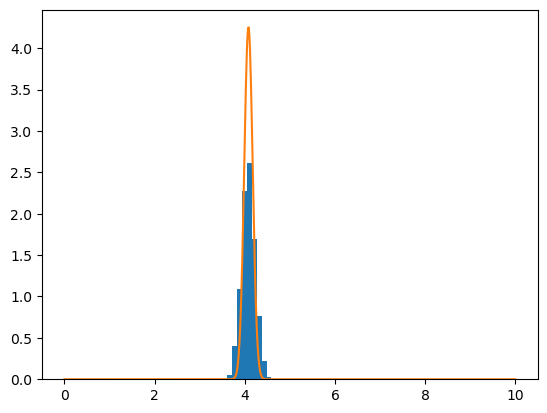

In [255]:
#plot the means as a histogram and plot the true distribution over that
xgrid = np.linspace(0,10,1000)
plt.hist(means,density=True)
plt.plot(xgrid,stat.norm(loc=mu_hat,scale=sigma_mu).pdf(xgrid))
plt.show()

SRT: Your boostrap histogram looks wider because each bootstrap realization was only half the size of the original dataset. No commentary on this? -2 points

Laplace distribution looks like this:

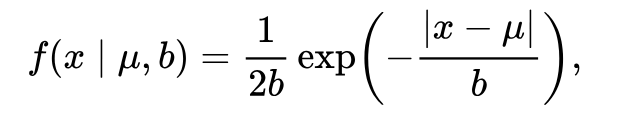

and from the helpful link Harrison posted (https://math.stackexchange.com/questions/2243898/maximum-likelihood-estimator-of-laplace-distribution) I was able to get:

I cannot for the life of me get the minimizing function for the laplacian and its too late to be working, this is my best guess after using just y-yfit abs to get the best results. All other code would be able to work minus the final question if this function could be found

In [308]:
def squared_loss_L(y,y_fit,dy,N):
    return -N * np.log(2*dy) - np.sum((abs(y - y_fit))/dy)

f_squared = lambda gamma: squared_loss_L(file[:,0],gamma[0],gamma[1],len(file))
beta0 = (1,1)
beta_squared = opt.fmin(f_squared, beta0, disp=False)
print(beta_squared)

[1.16661145e+00 2.96355297e-30]


/tmp/ipykernel_2453/2724824004.py:2: RuntimeWarning: invalid value encountered in log
  return -N * np.log(2*dy) - np.sum((abs(y - y_fit))/dy)


SRT: Correct definition, but since you are minimizing a function, you need to feed in the negative of the log likelihood. You have supplied the log likelihood itself. -2 points

ACM is given 

In [306]:
#7 Compute the maximum likelihoods by hand and then calculate the AICs and see which is greater
xgrid = np.linspace(3,5,10000)
Ls = np.ones((100,10000))
for i in range(len(file)):
    Ls[i] = stat.laplace.pdf(xgrid,loc=file[i,0],scale=file[i,1])
LL = np.prod(Ls,axis=0)

sorted_indices = np.argsort(LL) #Sort L to get the largest index value at the end
index_max = sorted_indices[len(sorted_indices)-1] #get that index and store it in a variable

k=2
N=100

AIC_L = -2 * np.log(LL[index_max]) + 2 * k + (2*k*(k+1))/(N-k-1)

k=1
sorted_indices = np.argsort(LG) #Sort L to get the largest index value at the end
index_max = sorted_indices[len(sorted_indices)-1] #get that index and store it in a variable

AIC_G = -2 * np.log(LG[index_max]) + 2 * k + (2*k*(k+1))/(N-k-1)

print("normal: ",AIC_G)
print("Laplace: ",AIC_L)

normal:  309.27790931725275
Laplace:  322.44136743112495


SRT: This is correct! So why didn't you just use the `scipy.stats.laplace.logpdf` functionality to fit the parameters against the data?

Therefore the normal fits the data better

In [294]:
#8 Grab the two different parameter fits and then make a corner plot
samples = np.zeros((2000,2))
for i in range(len(bootstraps)):
    f_squared = lambda gamma: squared_loss_L(bootstraps[i,:,0],gamma[0],gamma[1],len(bootstraps[i]))
    beta0 = (4,0.06)
    beta_squared = opt.fmin(squared_loss_L, beta0,disp=False)
    samples[i][0] = beta_squared[0]
    samples[i][1] = beta_squared[1]

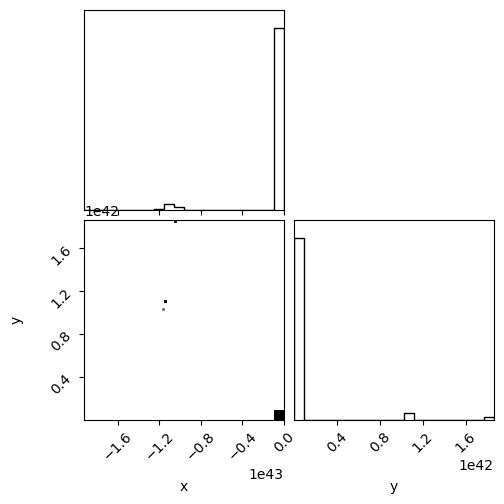

In [295]:
figure = corner.corner(samples,labels=["x","y"])

SRT: Correct procedure, with wrong-sign log likelihood. Incorrect labels on the parameters, and no attempt to include credible regions. -2 points

In [ ]:
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

SRT: Part 9 not attempted. -4 points

SRT: 33/50